## TESTING Merge OD and Tract data

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gp
import fiona
import shapely.geometry as geom

from pathlib import Path
import timeit
from IPython.display import clear_output
from pyproj import Geod
import numpy as np

#### Function - Convert decimal time to minutes and seconds

In [2]:
def get_time(timer):
    minutes, seconds = int(np.floor(timer)), round(np.asscalar(timer % 1)*60)
    return[minutes,  seconds]

In [3]:
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
  return dist

In [4]:
def chunk_preprocessing(df):
    # create the tract geoid columns for work and residence
    df['tract_w_geoid'] = df.w_geocode.str[:11]
    df['tract_h_geoid'] = df.h_geocode.str[:11]
    # create a group of all workplace geoids
    df_group = df.groupby(['tract_w_geoid']).sum()
    # include only the records with over 5000 employees in the tract
    df_group = df_group[(df_group['S000'] > 5000)]
    # create list of all tracts with > 5000 workers
    top_tracts_list = df_group.index.tolist()
    # create a dataframe with only tracts with > 5000
    df2 = df[df['tract_w_geoid'].isin(top_tracts_list)]
    # sort the datafra,e
    df2_sort= df2.sort_values(['tract_w_geoid','tract_h_geoid'], ascending=[True, True])
    # reorder df2_sort dataframe
    df2_sort = df2_sort.reset_index(drop=True)
    # drop the columns containing the geoid for blocks
    df2_sort.drop(['w_geocode','h_geocode'], axis=1, inplace=True)
    # reorder the columns of the dataframe
    cols = df2_sort.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df2_sort = df2_sort[cols ]
    # group the dataframe by the worker and home tract geoid
    df2_group = df2_sort.groupby(['tract_w_geoid','tract_h_geoid']).sum().reset_index()
    # load the centroid file
    centroids = pd.read_csv(tract_file, dtype={'tract_geoid': 'object', 'lat': 'float', 'lon': 'float'})
    # merge the centroid data frame with the grouped dataframe
    merge_result = pd.merge(df2_group, centroids,left_on=  ['tract_w_geoid'],right_on= ['tract_geoid'],how = 'left')
    merge_result.drop(['tract_geoid'], axis=1, inplace=True)
    merge_result.rename(columns={'lat': 'w_lat', 'lon': 'w_lon'}, inplace=True)
    # merge the centroid data frame on the Fayette county h_geocode column
    merge_result = pd.merge(merge_result, centroids,left_on=  ['tract_h_geoid'],right_on= ['tract_geoid'],how = 'left')
    merge_result.drop(['tract_geoid'], axis=1, inplace=True)
    merge_result.rename(columns={'lat': 'h_lat', 'lon': 'h_lon'}, inplace=True)
    merge_result['distance'] = Distance(merge_result['w_lat'].tolist(),merge_result['w_lon'].tolist(),merge_result['h_lat'].tolist(),merge_result['h_lon'].tolist())
    merge_result['distance'] = merge_result['distance'].apply(lambda x: round(x, decimals))
    return merge_result

In [5]:
ODpath = Path("../data/OD/")
OD_file = ODpath.joinpath("OD.csv.gz")
if OD_file.exists ():
    print ("File exist")
else:
    print ("File does not exist")
OD_out_file = ODpath.joinpath('OD_mod.csv')
tractPath = Path("../data/tracts/")
tract_file = tractPath.joinpath("tract_centroids.csv.gz")
if tract_file.exists ():
    print ("File exist")
else:
    print ("File does not exist")
tract_out_file = tractPath.joinpath('tract_mod.csv')

File exist
File exist


#### Read the Origin Destination (OD) data into chunk dataframes

In [6]:
%time df_chunk = pd.read_csv(OD_file, compression='gzip', dtype={'w_geocode': str,'h_geocode':str}, chunksize=10000000)

Wall time: 7.02 ms


In [7]:
chunk_list = []

In [8]:
wgs84_geod = Geod(ellps='WGS84') 
#Distance will be measured on this ellipsoid - more accurate than a spherical method

In [9]:
chunk_num = 1
decimals = 0   

print('Reading in the chunk dataframe')
start = timeit.default_timer()
for df in df_chunk:
    print('Starting processing for chunk #', chunk_num)
    # call function to group and filter the data 
    filter_chunk = chunk_preprocessing(df)
    # append the filtered data to list
    chunk_list.append(filter_chunk)
    
    # get the current time on timer
    stop = timeit.default_timer()
    timer = np.array([(stop-start)/60])
    min_sec = get_time(timer)
    minutes, seconds = min_sec[0], min_sec[1]
    
    clear_output(wait=True)
    print('Chunk number:', chunk_num)
    print('Length of dataframe:',"{:,}".format(len(filter_chunk)),'\n')
    print('Timer:', minutes, 'minutes', seconds, 'seconds')
    chunk_num += 1

print('\nData merge complete.')

Chunk number: 11
Length of dataframe: 352,344 

Timer: 6 minutes 18 seconds

Data merge complete.


In [54]:
# concat the list into dataframe 
%time df = pd.concat(chunk_list,sort=True)

Wall time: 644 ms


In [55]:
print('Dataframe length:',"{:,}".format(len(df)))

Dataframe length: 5,761,758


In [56]:
%time df_limited = df.copy()

Wall time: 487 ms


In [57]:
# include commuters that travel 20 - 100 miles
%time df_limited = df_limited[(df_limited['distance'] < 120000) & (df_limited['distance'] > 80000)]  

Wall time: 177 ms


In [58]:
# generate the geometry for geopandas
%time df_limited['geometry'] = df_limited.apply(lambda x: geom.LineString([(x['w_lon'], x['w_lat'] ), (x['h_lon'],x['h_lat'])]), axis = 1)

Wall time: 15.8 s


In [59]:
print('Dataframe length:',"{:,}".format(len(df_limited)))

Dataframe length: 600,981


In [60]:
gdf = gp.GeoDataFrame(df_limited, geometry='geometry')

Wall time: 15.3 s


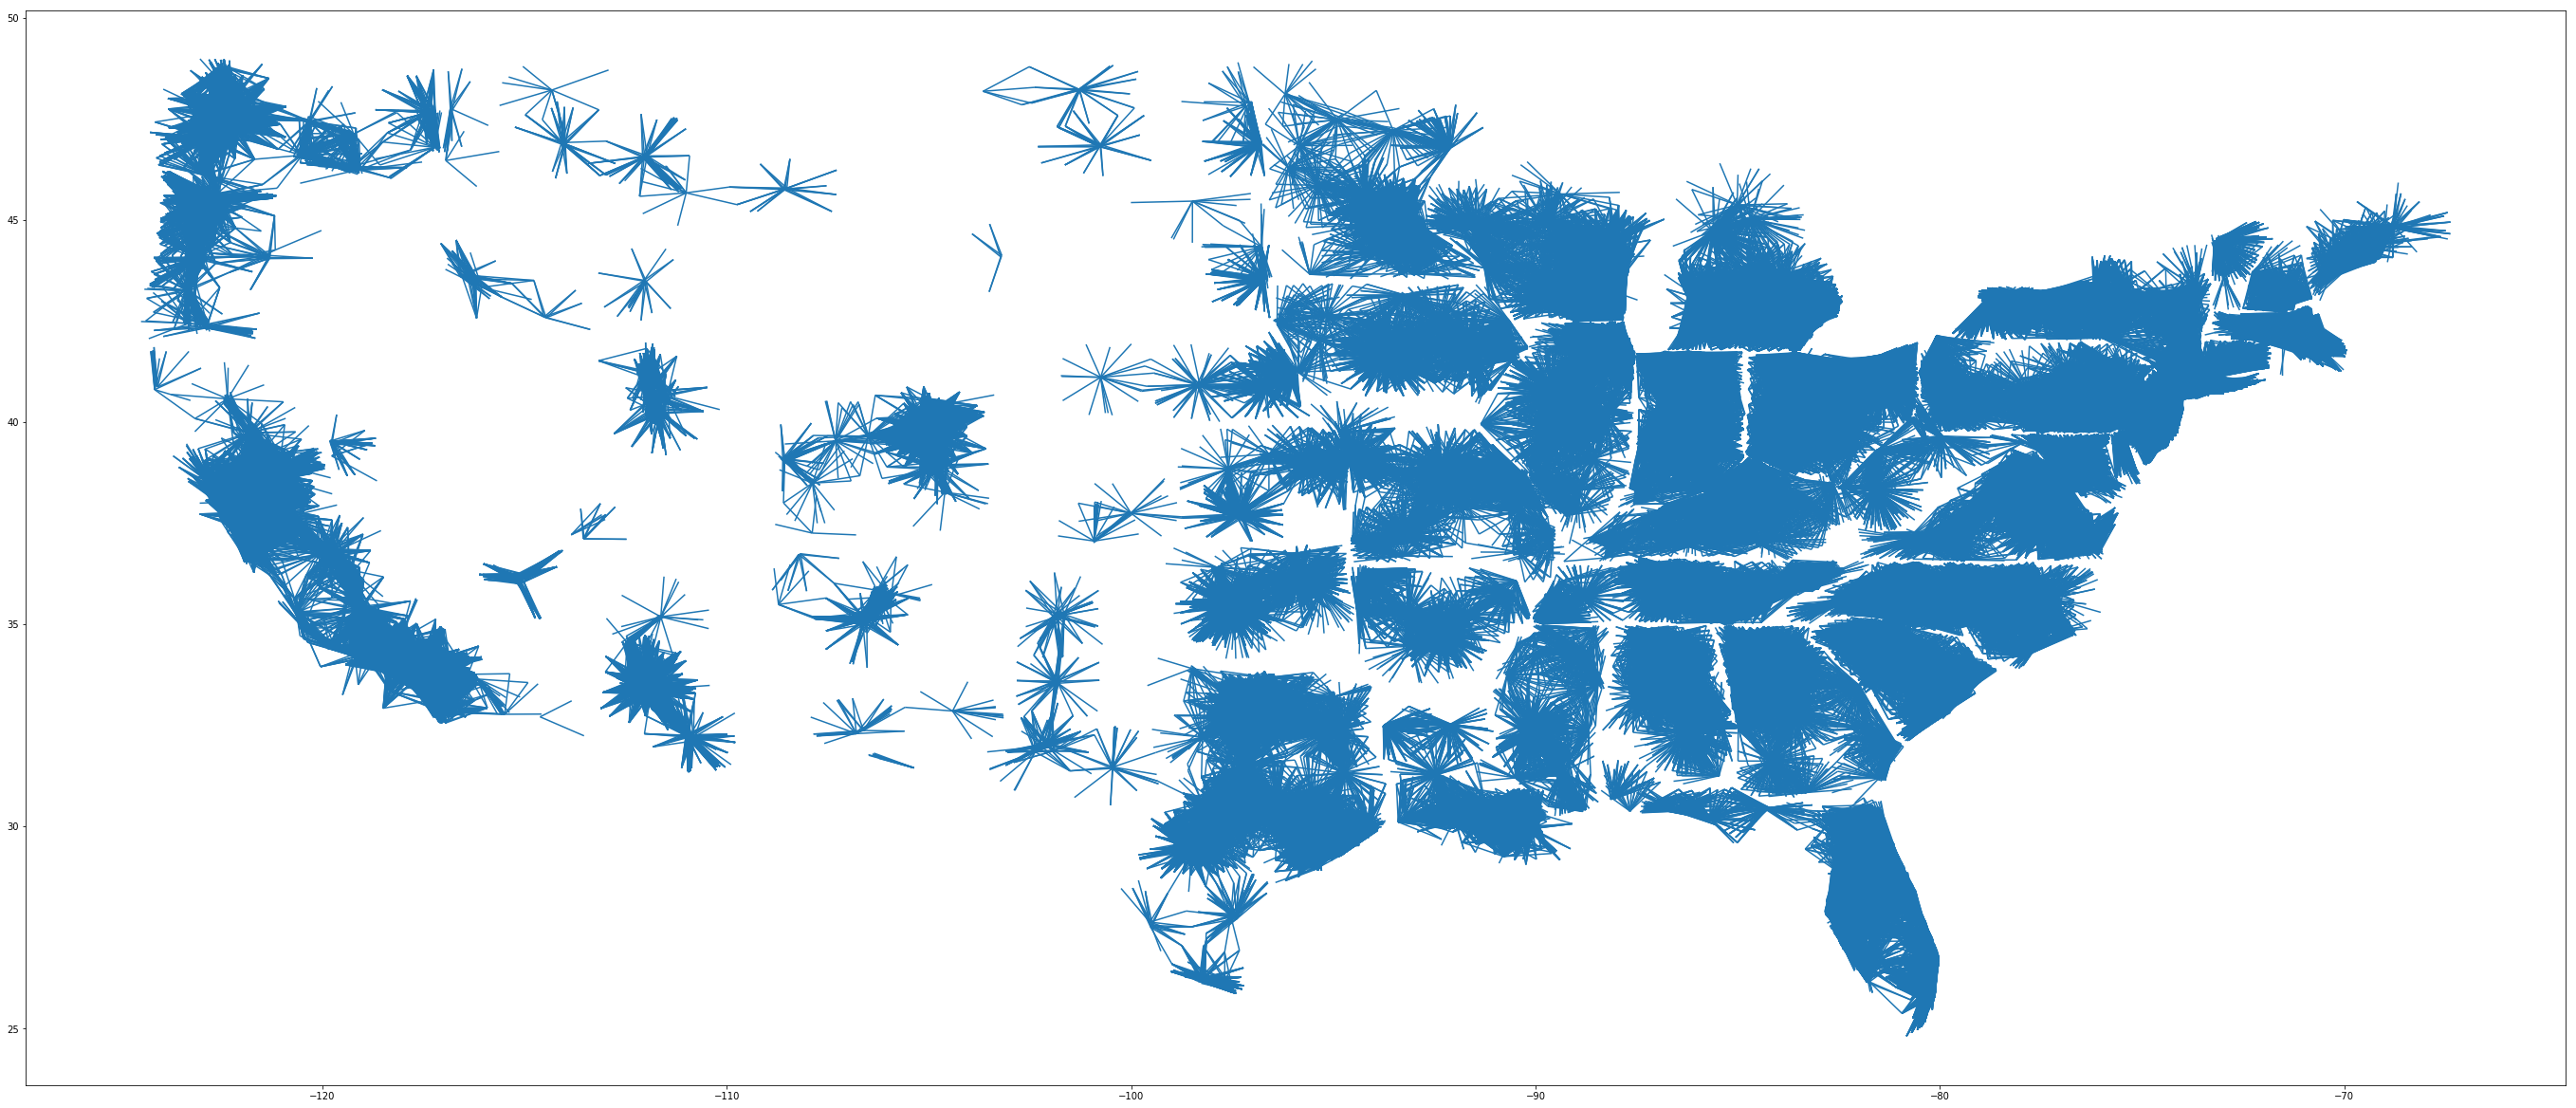

In [61]:
%time ax =gdf.plot(figsize=(48,48));

In [62]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 600981 entries, 9 to 352309
Data columns (total 18 columns):
S000             600981 non-null int64
SA01             600981 non-null int64
SA02             600981 non-null int64
SA03             600981 non-null int64
SE01             600981 non-null int64
SE02             600981 non-null int64
SE03             600981 non-null int64
SI01             600981 non-null int64
SI02             600981 non-null int64
SI03             600981 non-null int64
distance         600981 non-null float64
h_lat            600981 non-null float64
h_lon            600981 non-null float64
tract_h_geoid    600981 non-null object
tract_w_geoid    600981 non-null object
w_lat            600981 non-null float64
w_lon            600981 non-null float64
geometry         600981 non-null object
dtypes: float64(5), int64(10), object(3)
memory usage: 87.1+ MB


#### Create a dataframe of KY worker locations

In [63]:
df_ky = df.copy()
df_ky.head()

S000  SA01  SA02  SA03  SE01  SE02  SE03  SI01  SI02  SI03  distance  \
0     1     0     1     0     0     0     1     0     0     1  258564.0   
1     1     0     0     1     1     0     0     0     1     0  259259.0   
2     4     2     1     1     2     2     0     0     3     1  259053.0   
3     1     0     1     0     0     1     0     0     1     0  255560.0   
4     2     0     0     2     0     2     0     0     1     1  250559.0   

       h_lat      h_lon tract_h_geoid tract_w_geoid      w_lat      w_lon  
0  32.475758 -86.472468   01001020200   01003011502  30.379884 -87.665057  
1  32.471030 -86.444835   01001020400   01003011502  30.379884 -87.665057  
2  32.458922 -86.421826   01001020500   01003011502  30.379884 -87.665057  
3  32.447340 -86.476828   01001020600   01003011502  30.379884 -87.665057  
4  32.418082 -86.527138   01001020801   01003011502  30.379884 -87.665057

In [64]:
df_ky = df_ky[df_ky['tract_w_geoid'].str.startswith('21')]
len(df_ky)

37595

In [73]:
# include commuters that travel 20 - 100 miles
%time df_ky = df_ky[(df_ky['distance'] < 120000) & (df_ky['distance'] > 80000)]  

Wall time: 3.01 ms


In [74]:
# generate the geometry for geopandas
%time df_ky['geometry'] = df_ky.apply(lambda x: geom.LineString([(x['w_lon'], x['w_lat'] ), (x['h_lon'],x['h_lat'])]), axis = 1)

Wall time: 300 ms


In [75]:
print('Dataframe length:',"{:,}".format(len(df_ky)))

Dataframe length: 8,190


In [76]:
gdf = gp.GeoDataFrame(df_ky, geometry='geometry')

Wall time: 418 ms


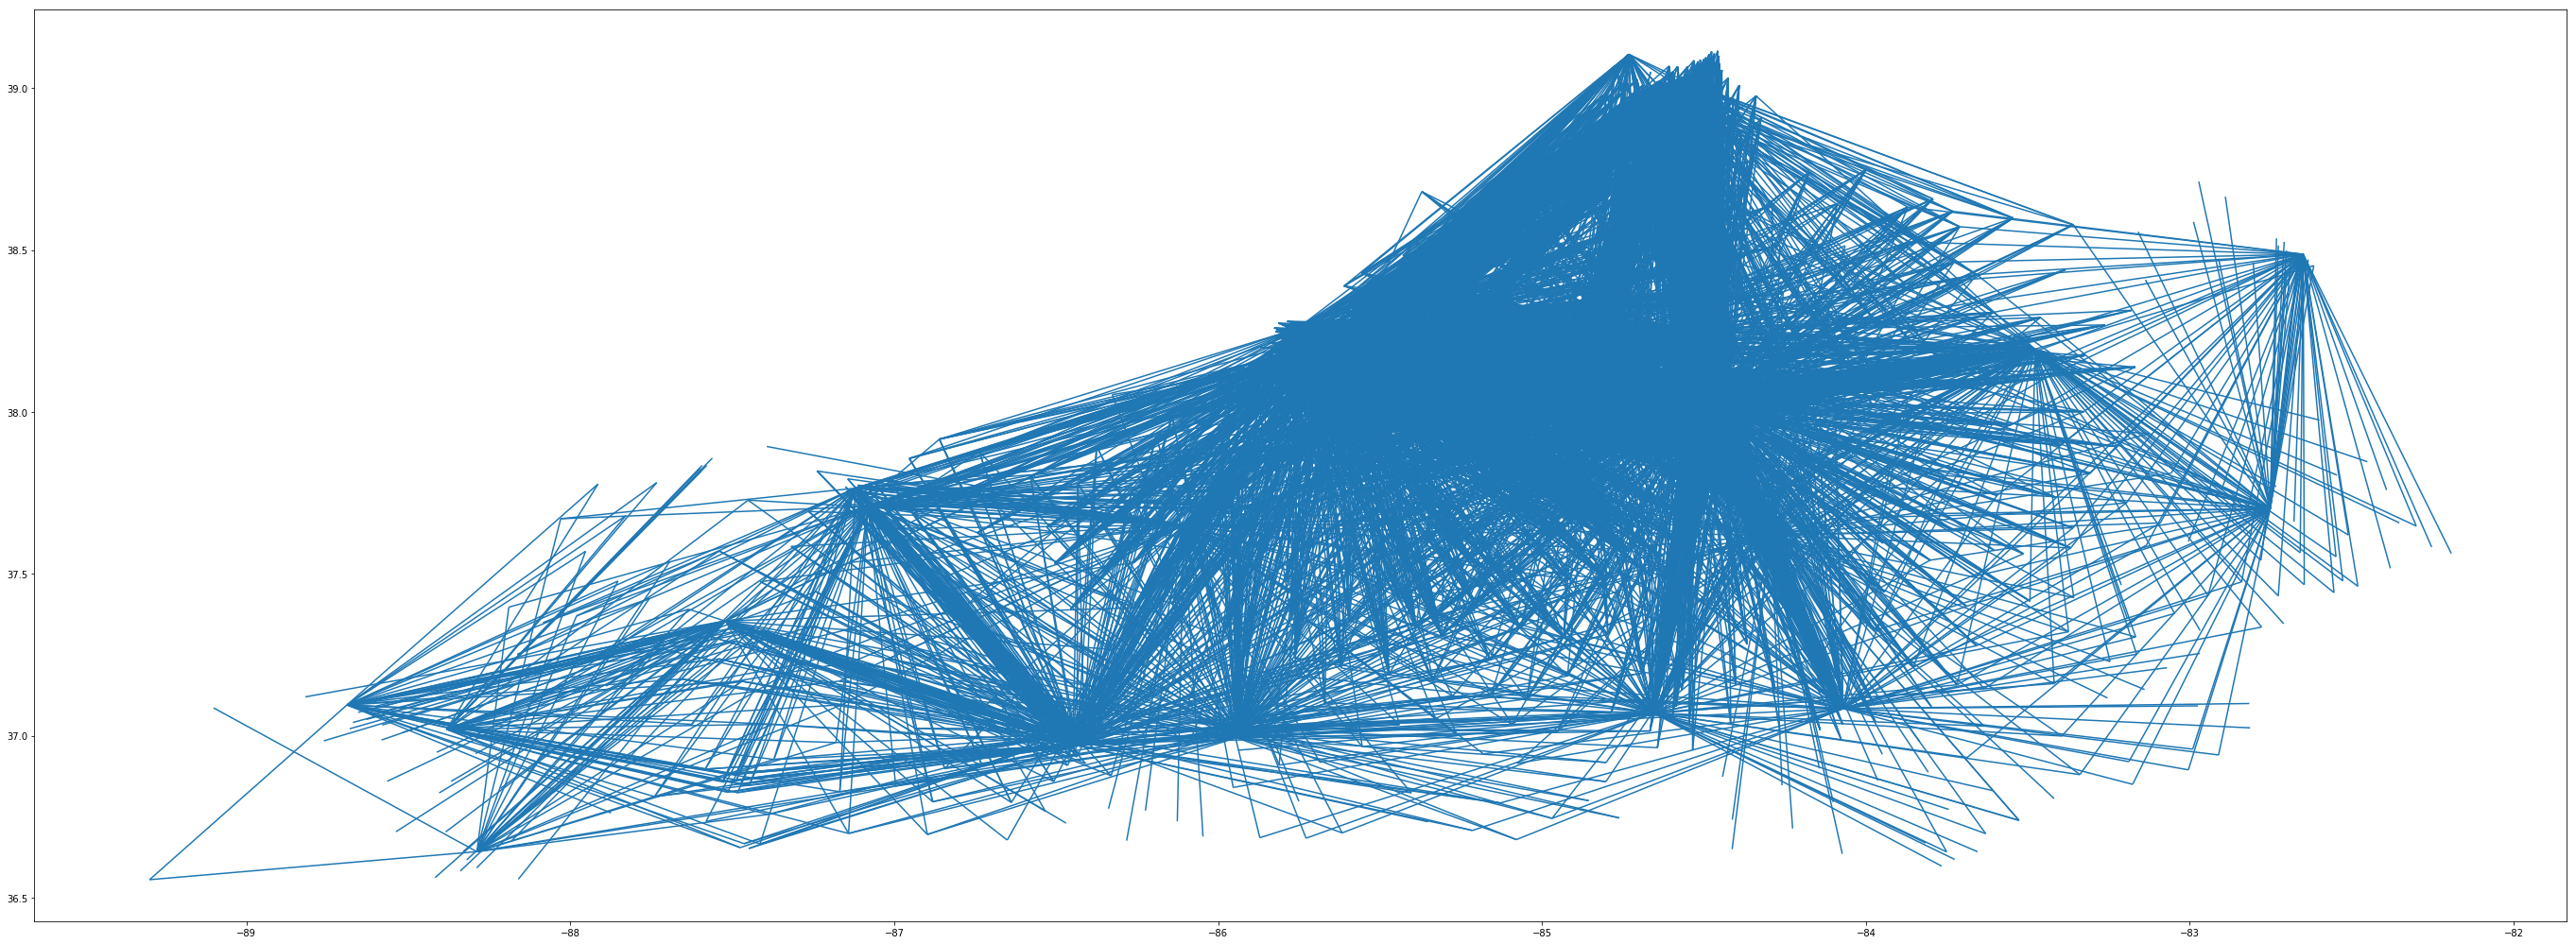

In [77]:
%time ax =gdf.plot(figsize=(48,48));

In [78]:
lex_ky = df.copy()
lex_ky.head()

S000  SA01  SA02  SA03  SE01  SE02  SE03  SI01  SI02  SI03  distance  \
0     1     0     1     0     0     0     1     0     0     1  258564.0   
1     1     0     0     1     1     0     0     0     1     0  259259.0   
2     4     2     1     1     2     2     0     0     3     1  259053.0   
3     1     0     1     0     0     1     0     0     1     0  255560.0   
4     2     0     0     2     0     2     0     0     1     1  250559.0   

       h_lat      h_lon tract_h_geoid tract_w_geoid      w_lat      w_lon  
0  32.475758 -86.472468   01001020200   01003011502  30.379884 -87.665057  
1  32.471030 -86.444835   01001020400   01003011502  30.379884 -87.665057  
2  32.458922 -86.421826   01001020500   01003011502  30.379884 -87.665057  
3  32.447340 -86.476828   01001020600   01003011502  30.379884 -87.665057  
4  32.418082 -86.527138   01001020801   01003011502  30.379884 -87.665057

In [80]:
lex_ky = lex_ky[lex_ky['tract_w_geoid'].str.startswith('21067')]
len(lex_ky)

6288

In [81]:
# include commuters that travel 20 - 100 miles
%time lex_ky = lex_ky[(lex_ky['distance'] < 120000) & (lex_ky['distance'] > 80000)]  

Wall time: 2 ms


In [82]:
# generate the geometry for geopandas
%time lex_ky['geometry'] = lex_ky.apply(lambda x: geom.LineString([(x['w_lon'], x['w_lat'] ), (x['h_lon'],x['h_lat'])]), axis = 1)

Wall time: 389 ms


In [83]:
print('Dataframe length:',"{:,}".format(len(lex_ky)))

Dataframe length: 2,220


In [84]:
gdf = gp.GeoDataFrame(lex_ky, geometry='geometry')

Wall time: 245 ms


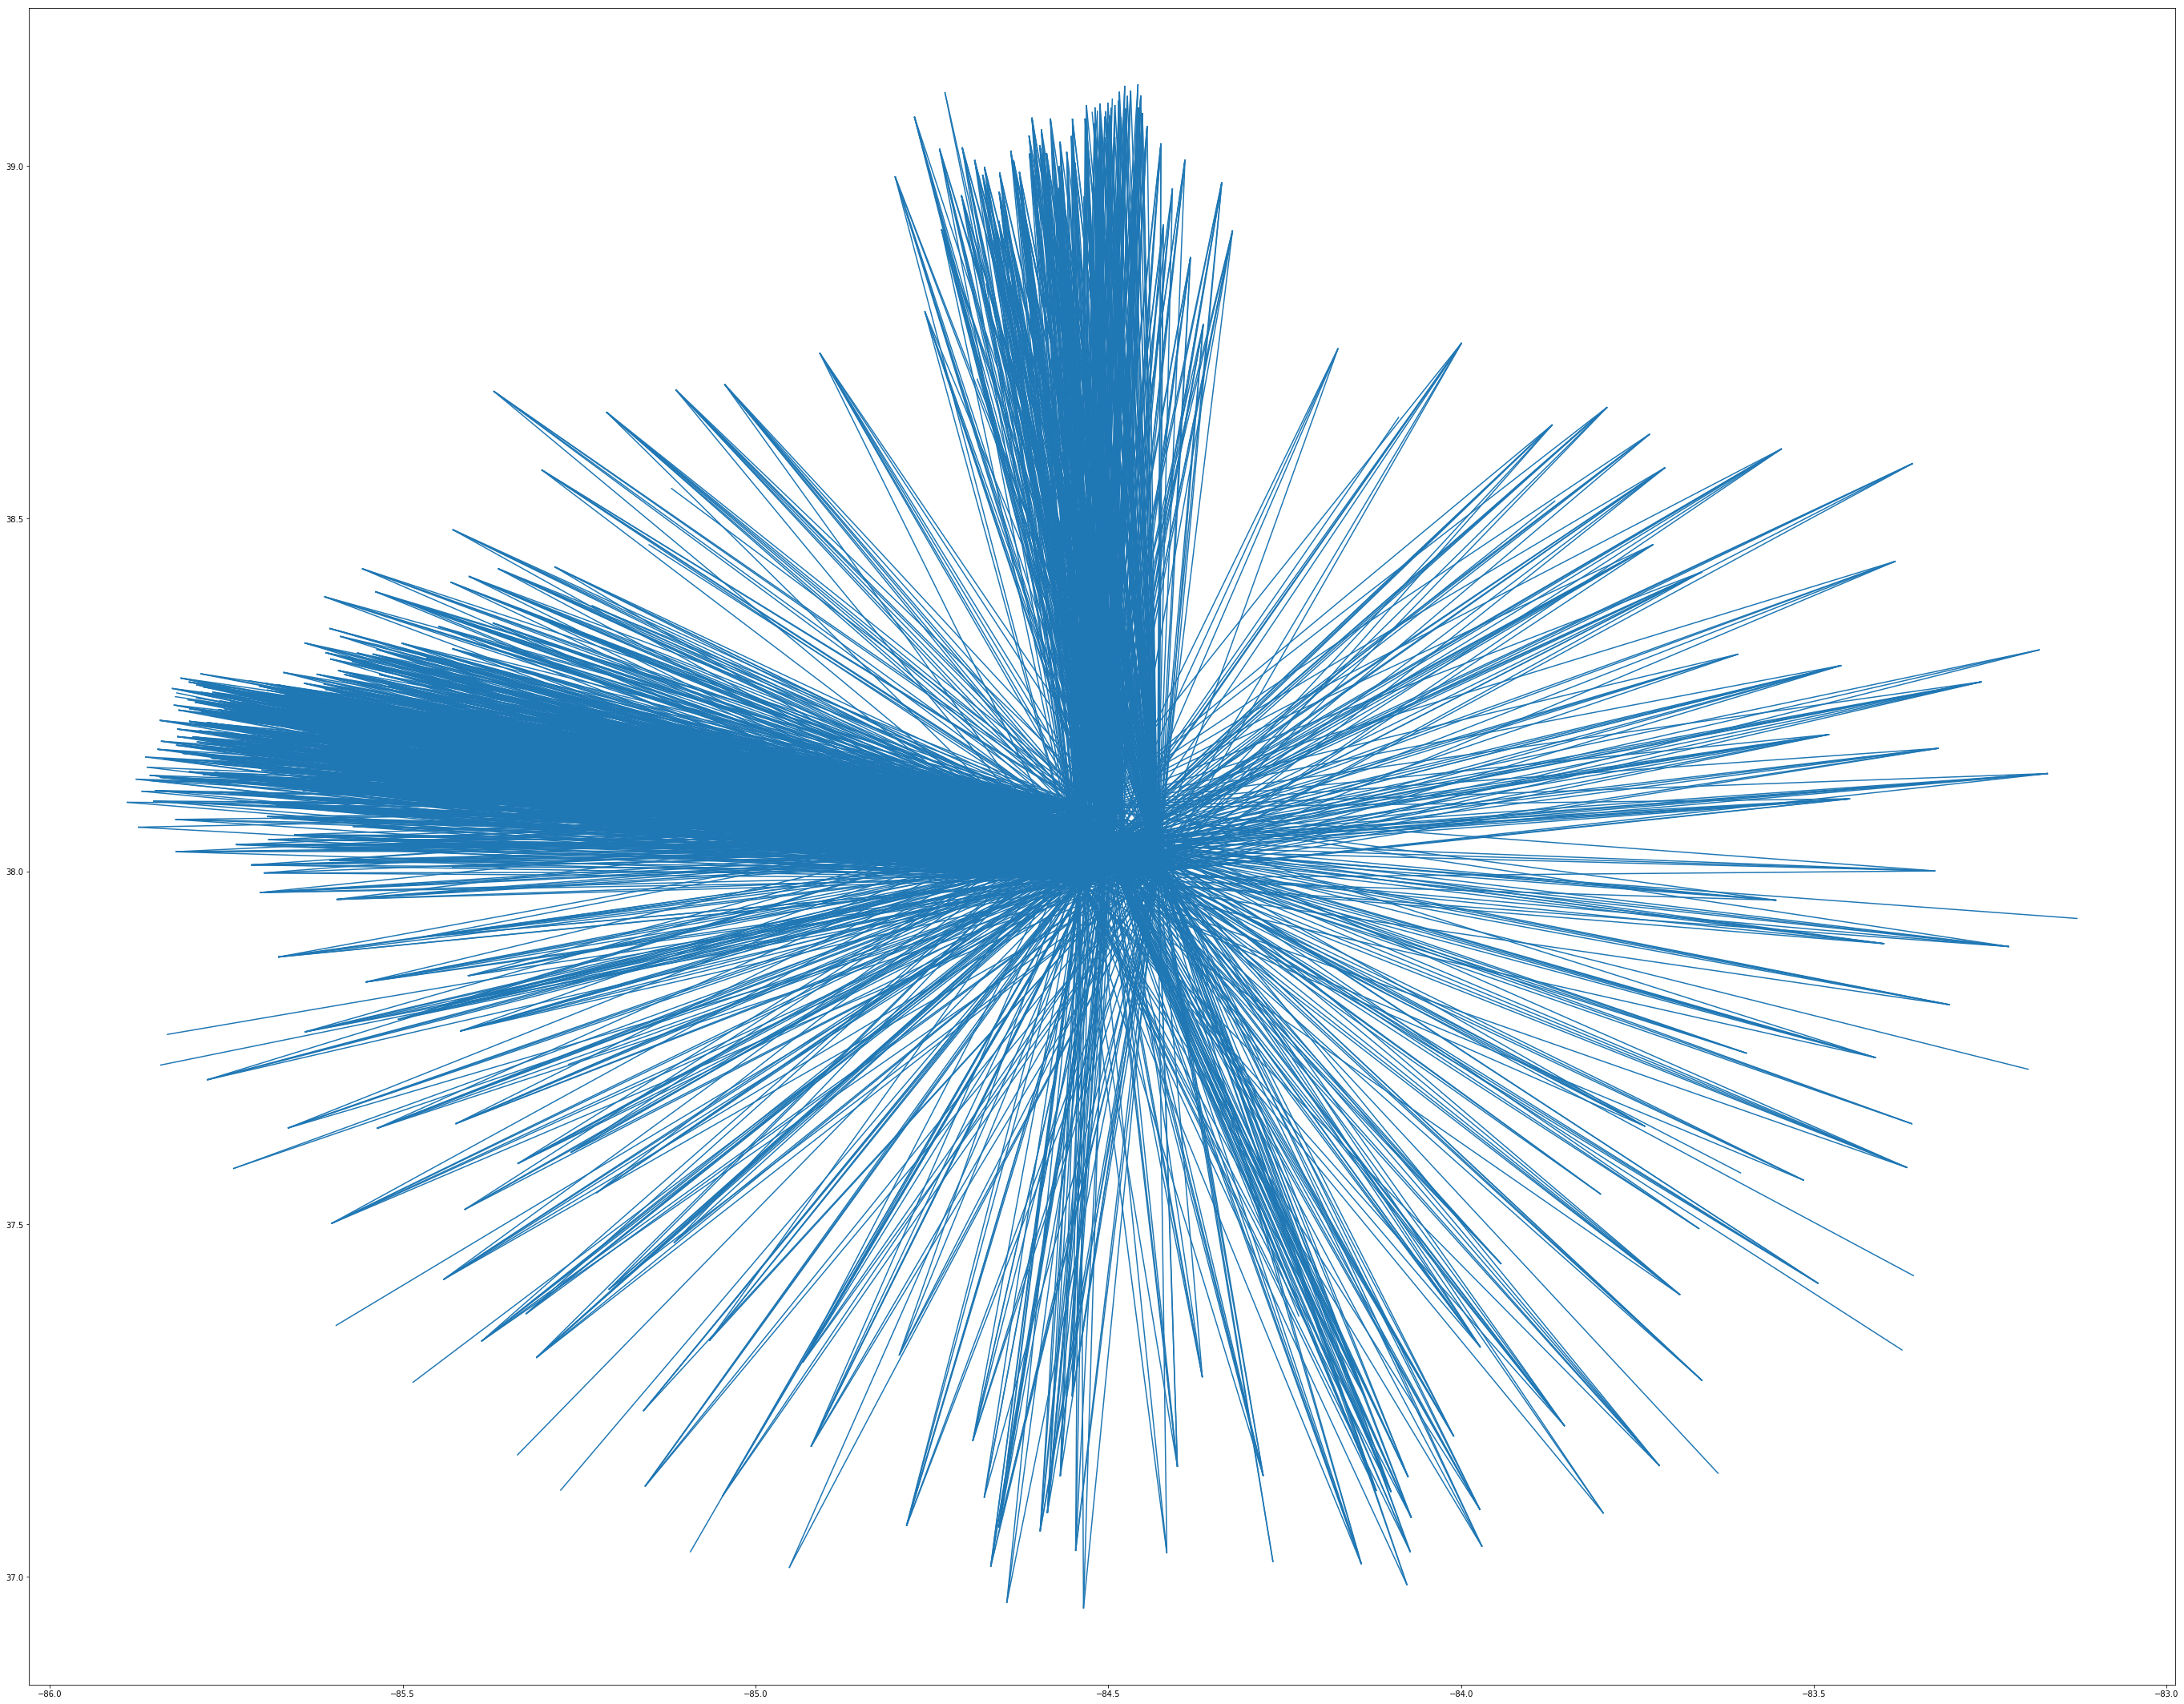

In [85]:
%time ax =gdf.plot(figsize=(48,48));

#### Write file to GeoJSON

In [86]:
gdf.to_file("lex.json", driver="GeoJSON")

C:\Users\mdcr226\AppData\Local\Continuum\anaconda3\envs\sandbox\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
